In [25]:
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np
import pickle

sns.set_style("darkgrid")

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

######################################################################

from xgboost import XGBRegressor
import xgboost as xgb

# from ray import tune

######################################################################

# All functions are stored in the src folder attached to this repo
from src.clean_data import clean_data

######################################################################
import warnings
warnings.filterwarnings('ignore')



In [26]:
df = clean_data()

In [3]:
df.head()

,name,currentAge,birthCountry,weight,alternateCaptain,captain,rookie,shootsCatches,timeOnIce22,assists22,goals22,pim22,shots22,games22,hits22,powerPlayGoals22,powerPlayPoints22,powerPlayTimeOnIce22,evenTimeOnIce22,penaltyMinutes22,faceOffPct22,shotPct22,gameWinningGoals22,overTimeGoals22,shortHandedGoals22,shortHandedPoints22,shortHandedTimeOnIce22,blocked22,plusMinus22,points22,shifts22,timeOnIcePerGame22,evenTimeOnIcePerGame22,shortHandedTimeOnIcePerGame22,powerPlayTimeOnIcePerGame22,timeOnIce21,assists21,goals21,pim21,shots21,games21,hits21,powerPlayGoals21,powerPlayPoints21,powerPlayTimeOnIce21,evenTimeOnIce21,penaltyMinutes21,faceOffPct21,shotPct21,gameWinningGoals21,overTimeGoals21,shortHandedGoals21,shortHandedPoints21,shortHandedTimeOnIce21,blocked21,plusMinus21,points21,shifts21,timeOnIcePerGame21,evenTimeOnIcePerGame21,shortHandedTimeOnIcePerGame21,powerPlayTimeOnIcePerGame21,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,Salary_2021-22,career_shortHandedPoints,career_powerPlayGoals,career_powerPlayTimeOnIcePerGame,career_shortHandedTimeOnIce,career_shortHandedGoals,career_evenTimeOnIce,career_shortHandedTimeOnIcePerGame,career_penaltyMinutes,career_gameWinningGoals,career_timeOnIcePerGame,career_assists,career_blocked,career_points,career_hits,career_shifts,career_powerPlayTimeOnIce,career_plusMinus,career_powerPlayPoints,career_evenTimeOnIcePerGame,career_goals,career_overTimeGoals,career_pim,career_games,career_timeOnIce,career_shots
0,Defenseman,32,CAN,210,True,False,False,Right,1408.48,17.0,5.0,82.0,114.0,77.0,69.0,0.0,0.0,45.05,1296.37,82.0,0.0,4.4,1.0,0.0,0.0,1.0,67.06,90.0,-8.0,22.0,1755.0,18.17,16.50,0.52,0.35,983.47,14.0,5.0,26.0,99.0,44.0,41.0,2.0,5.0,89.48,827.53,26.0,0.0,5.1,0.0,0.0,0.0,0.0,66.06,46.0,-16.0,19.0,1152.0,22.21,18.48,1.30,2.02,1504.25,11.0,7.0,79.0,151.0,68.0,88.0,2.0,6.0,160.14,1232.41,79.0,0.0,4.6,3.0,0.0,0.0,0.0,111.30,90.0,-21.0,18.0,1883.0,22.07,18.07,1.38,2.21,1427.51,22.0,9.0,60.0,168.0,63.0,56.0,2.0,10.0,163.07,1166.17,60.0,0.0,5.36,1.0,0.0,1.0,1.0,98.27,75.0,5.0,31.0,1731.0,22.39,18.30,1.33,2.35,1977.24,43.0,16.0,82.0,207.0,82.0,111.0,5.0,25.0,253.23,1507.00,82.0,33.33,7.73,2.0,0.0,0.0,1.0,217.01,90.0,18.0,59.0,2323.0,24.06,18.22,2.38,3.05,1610.400000,30.000000,10.000000,44.000000,142.000000,66.000000,78.000000,3.000000,16.000000,172.000000,1300.430000,44.000000,0.000000,7.040000,2.00000,0.000000,0.000000,1.000000,137.570000,10

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Columns: 196 entries, name to career_shots
dtypes: bool(3), float64(188), int64(2), object(3)
memory usage: 607.4+ KB


In [5]:
df['birthCountry'].value_counts()

CAN      158
OTHER    123
USA      121
Name: birthCountry, dtype: int64

In [6]:
birth_country = pd.get_dummies(df['birthCountry'], prefix='birthCountry')
df = pd.concat([df, birth_country], axis=1)
df.drop('birthCountry', axis=1, inplace=True)

In [7]:
df["shoots_L"] = pd.get_dummies(df['shootsCatches'])["Left"]
df["shoots_R"] = pd.get_dummies(df['shootsCatches'])["Right"]
df.drop("shootsCatches", axis=1, inplace=True)

In [8]:
df.head()

,name,currentAge,weight,alternateCaptain,captain,rookie,timeOnIce22,assists22,goals22,pim22,shots22,games22,hits22,powerPlayGoals22,powerPlayPoints22,powerPlayTimeOnIce22,evenTimeOnIce22,penaltyMinutes22,faceOffPct22,shotPct22,gameWinningGoals22,overTimeGoals22,shortHandedGoals22,shortHandedPoints22,shortHandedTimeOnIce22,blocked22,plusMinus22,points22,shifts22,timeOnIcePerGame22,evenTimeOnIcePerGame22,shortHandedTimeOnIcePerGame22,powerPlayTimeOnIcePerGame22,timeOnIce21,assists21,goals21,pim21,shots21,games21,hits21,powerPlayGoals21,powerPlayPoints21,powerPlayTimeOnIce21,evenTimeOnIce21,penaltyMinutes21,faceOffPct21,shotPct21,gameWinningGoals21,overTimeGoals21,shortHandedGoals21,shortHandedPoints21,shortHandedTimeOnIce21,blocked21,plusMinus21,points21,shifts21,timeOnIcePerGame21,evenTimeOnIcePerGame21,shortHandedTimeOnIcePerGame21,powerPlayTimeOnIcePerGame21,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,Salary_2021-22,career_shortHandedPoints,career_powerPlayGoals,career_powerPlayTimeOnIcePerGame,career_shortHandedTimeOnIce,career_shortHandedGoals,career_evenTimeOnIce,career_shortHandedTimeOnIcePerGame,career_penaltyMinutes,career_gameWinningGoals,career_timeOnIcePerGame,career_assists,career_blocked,career_points,career_hits,career_shifts,career_powerPlayTimeOnIce,career_plusMinus,career_powerPlayPoints,career_evenTimeOnIcePerGame,career_goals,career_overTimeGoals,career_pim,career_games,career_timeOnIce,career_shots,birthCountry_CAN,birthCountry_OTHER,birthCountry_USA,shoots_L,shoots_R
0,Defenseman,32,210,True,False,False,1408.48,17.0,5.0,82.0,114.0,77.0,69.0,0.0,0.0,45.05,1296.37,82.0,0.0,4.4,1.0,0.0,0.0,1.0,67.06,90.0,-8.0,22.0,1755.0,18.17,16.50,0.52,0.35,983.47,14.0,5.0,26.0,99.0,44.0,41.0,2.0,5.0,89.48,827.53,26.0,0.0,5.1,0.0,0.0,0.0,0.0,66.06,46.0,-16.0,19.0,1152.0,22.21,18.48,1.30,2.02,1504.25,11.0,7.0,79.0,151.0,68.0,88.0,2.0,6.0,160.14,1232.41,79.0,0.0,4.6,3.0,0.0,0.0,0.0,111.30,90.0,-21.0,18.0,1883.0,22.07,18.07,1.38,2.21,1427.51,22.0,9.0,60.0,168.0,63.0,56.0,2.0,10.0,163.07,1166.17,60.0,0.0,5.36,1.0,0.0,1.0,1.0,98.27,75.0,5.0,31.0,1731.0,22.39,18.30,1.33,2.35,1977.24,43.0,16.0,82.0,207.0,82.0,111.0,5.0,25.0,253.23,1507.00,82.0,33.33,7.73,2.0,0.0,0.0,1.0,217.01,90.0,18.0,59.0,2323.0,24.06,18.22,2.38,3.05,1610.400000,30.000000,10.000000,44.000000,142.000000,66.000000,78.000000,3.000000,16.000000,172.000000,1300.430000,44.000000,0.000000,7.040000,2.00000,0.0000

In [9]:
pos_cat = pd.get_dummies(df['name'], prefix="pos")

pos_map = {"pos_Center": "pos_center",
           "pos_Defenseman": "pos_def",
           "pos_Left Wing": "pos_leftwing",
           "pos_Right Wing": "pos_rightwing"}

pos_cat = pos_cat.rename(columns = pos_map)
df = pd.concat([df, pos_cat], axis=1)
df.drop("name", axis=1, inplace=True)

In [10]:
alt_capt = pd.get_dummies(df['alternateCaptain'], prefix='alt_capt')
capt = pd.get_dummies(df['captain'], prefix = 'capt')
rook = pd.get_dummies(df['rookie'], prefix='rook')

df = pd.concat([df,alt_capt,capt,rook], axis=1)
df.drop(['alternateCaptain','captain','rookie'], axis=1, inplace=True)

In [11]:
df['currentAge'] = df['currentAge'].astype('float')
df['weight'] = df['weight'].astype('float')

In [12]:
df.head()

,currentAge,weight,timeOnIce22,assists22,goals22,pim22,shots22,games22,hits22,powerPlayGoals22,powerPlayPoints22,powerPlayTimeOnIce22,evenTimeOnIce22,penaltyMinutes22,faceOffPct22,shotPct22,gameWinningGoals22,overTimeGoals22,shortHandedGoals22,shortHandedPoints22,shortHandedTimeOnIce22,blocked22,plusMinus22,points22,shifts22,timeOnIcePerGame22,evenTimeOnIcePerGame22,shortHandedTimeOnIcePerGame22,powerPlayTimeOnIcePerGame22,timeOnIce21,assists21,goals21,pim21,shots21,games21,hits21,powerPlayGoals21,powerPlayPoints21,powerPlayTimeOnIce21,evenTimeOnIce21,penaltyMinutes21,faceOffPct21,shotPct21,gameWinningGoals21,overTimeGoals21,shortHandedGoals21,shortHandedPoints21,shortHandedTimeOnIce21,blocked21,plusMinus21,points21,shifts21,timeOnIcePerGame21,evenTimeOnIcePerGame21,shortHandedTimeOnIcePerGame21,powerPlayTimeOnIcePerGame21,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,Salary_2021-22,career_shortHandedPoints,career_powerPlayGoals,career_powerPlayTimeOnIcePerGame,career_shortHandedTimeOnIce,career_shortHandedGoals,career_evenTimeOnIce,career_shortHandedTimeOnIcePerGame,career_penaltyMinutes,career_gameWinningGoals,career_timeOnIcePerGame,career_assists,career_blocked,career_points,career_hits,career_shifts,career_powerPlayTimeOnIce,career_plusMinus,career_powerPlayPoints,career_evenTimeOnIcePerGame,career_goals,career_overTimeGoals,career_pim,career_games,career_timeOnIce,career_shots,birthCountry_CAN,birthCountry_OTHER,birthCountry_USA,shoots_L,shoots_R,pos_center,pos_def,pos_leftwing,pos_rightwing,alt_capt_False,alt_capt_True,capt_False,capt_True,rook_False,rook_True
0,32.0,210.0,1408.48,17.0,5.0,82.0,114.0,77.0,69.0,0.0,0.0,45.05,1296.37,82.0,0.0,4.4,1.0,0.0,0.0,1.0,67.06,90.0,-8.0,22.0,1755.0,18.17,16.50,0.52,0.35,983.47,14.0,5.0,26.0,99.0,44.0,41.0,2.0,5.0,89.48,827.53,26.0,0.0,5.1,0.0,0.0,0.0,0.0,66.06,46.0,-16.0,19.0,1152.0,22.21,18.48,1.30,2.02,1504.25,11.0,7.0,79.0,151.0,68.0,88.0,2.0,6.0,160.14,1232.41,79.0,0.0,4.6,3.0,0.0,0.0,0.0,111.30,90.0,-21.0,18.0,1883.0,22.07,18.07,1.38,2.21,1427.51,22.0,9.0,60.0,168.0,63.0,56.0,2.0,10.0,163.07,1166.17,60.0,0.0,5.36,1.0,0.0,1.0,1.0,98.27,75.0,5.0,31.0,1731.0,22.39,18.30,1.33,2.35,1977.24,43.0,16.0,82.0,207.0,82.0,111.0,5.0,25.0,253.23,1507.00,82.0,33.33,7.73,2.0,0.0,0.0,1.0,217.01,90.0,18.0,59.0,2323.0,24.06,18.22,2.38,3.05,1610.400000,30.000000,10.000000,44.000000,142.000000,66.000000,78.000000,3.000000,16.000000,172.00000

In [13]:
df.isna().sum().value_counts()

0    205
dtype: int64

In [14]:
X = df.drop(['Salary_2021-22'], axis=1)
y = df['Salary_2021-22']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, random_state=42)

In [15]:
regr = RandomForestRegressor(max_features=10, random_state=42)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 1116933.4103960397


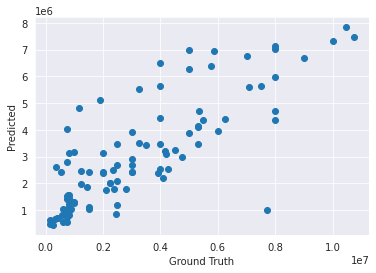

In [16]:
plt.scatter(y_test, y_pred)
plt.xlabel('Ground Truth')
plt.ylabel('Predicted');

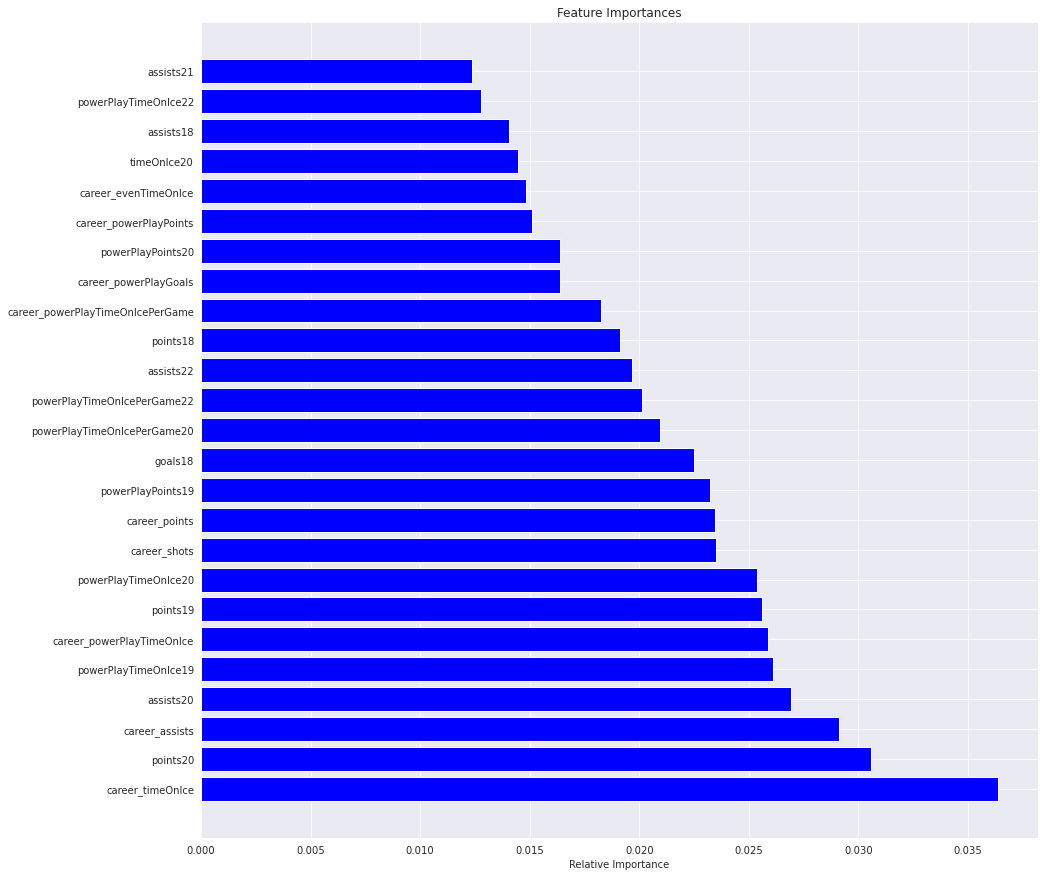

In [17]:
def plot_feat_import(num_feats):
    features = X.columns
    importances = regr.feature_importances_
    indices = np.argsort(importances)
    
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_title('Feature Importances')
    ax.barh(range(0,num_feats), importances[indices[::-1][:num_feats]], color='b', align='center')
    ax.set_yticks(range(0,num_feats))
    ax.set_yticklabels([features[i] for i in indices[::-1][:num_feats]])
    ax.set_xlabel('Relative Importance');

plot_feat_import(25)

In [18]:
season_22 = [col for col in df.columns if '22' in col and 'Salary' not in col]
career = [col for col in df.columns if 'career' in col]
age_weight = [col for col in df.columns if 'Age' in col or 'weight' in col]

Mean Absolute Error: 1277484.6547524752


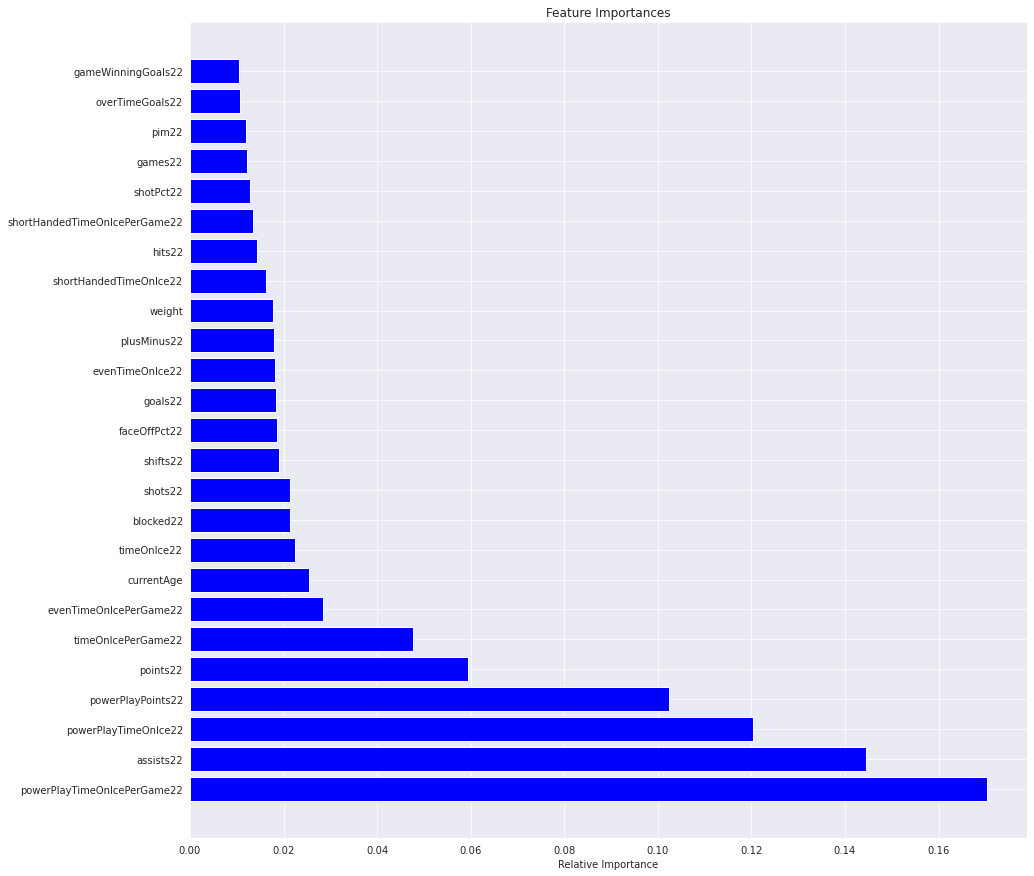

In [19]:
X = df[season_22 + age_weight]
y = df['Salary_2021-22']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, random_state=42)

regr = RandomForestRegressor(max_features=10, random_state=42)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

plot_feat_import(25)

Mean Absolute Error: 1198118.8108910893


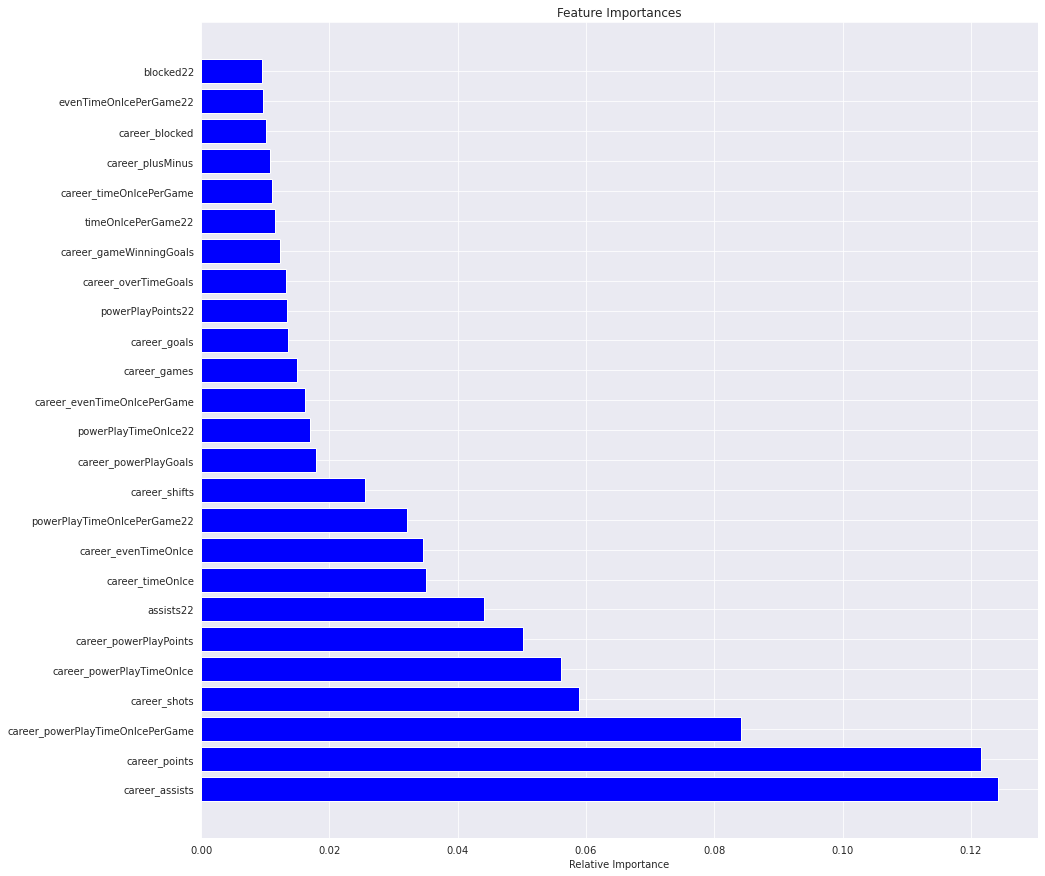

In [20]:
X = df[season_22 + age_weight + career]
y = df['Salary_2021-22']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, random_state=42)

regr = RandomForestRegressor(max_features=10, random_state=42)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

plot_feat_import(25)


In [21]:
features = X.columns
importances = regr.feature_importances_
indices = np.argsort(importances)

In [24]:
top10

Index(['career_assists', 'career_points', 'career_powerPlayTimeOnIcePerGame',
       'career_shots', 'career_powerPlayTimeOnIce', 'career_powerPlayPoints',
       'assists22', 'career_timeOnIce', 'career_evenTimeOnIce',
       'powerPlayTimeOnIcePerGame22'],
      dtype='object')

In [23]:
top10 = X.columns[indices[::-1]][:10]
X_top_10 = X[top10]

X_top_10.head()

,career_assists,career_points,career_powerPlayTimeOnIcePerGame,career_shots,career_powerPlayTimeOnIce,career_powerPlayPoints,assists22,career_timeOnIce,career_evenTimeOnIce,powerPlayTimeOnIcePerGame22
0,137.000000,189.000000,12.340000,881.000000,882.970000,62.000000,17.0,8911.350000,7329.910000,0.35
1,73.000000,79.000000,1.340000,244.000000,99.210000,4.000000,4.0,5063.970000,4445.640000,0.01
2,147.000000,192.000000,11.090000,755.000000,933.610000,59.000000,35.0,9662.390000,8062.930000,2.19
3,116.664179,143.906716,8.929291,444.839552,661.977799,49.421642,6.0,5894.452612,5138.615933,0.40
4,56.000000,121.000000,6.110000,704.000000,395.230000,13.000000,0.0,4347.130000,3940.380000,1.16


In [ ]:
asdfasd

In [ ]:
X_top_10.corr()

In [ ]:
X = X_top_10
y = df['Salary_2021-22']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, random_state=42)

regr = RandomForestRegressor(max_features=10, random_state=42)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

plot_feat_import(10)

In [ ]:
X_top_10.columns

In [ ]:
X = X_top_10
y = df['Salary_2021-22']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

numeric_features = X_train.select_dtypes(['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler',  StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', RandomForestRegressor(random_state=42))])

clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat))


In [ ]:
numeric_features = X_train.columns.tolist()


numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(random_state=42))])
param_grid = {
    'classifier__n_estimators': range(0,100,1),
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [1,2,3],
    'classifier__min_samples_leaf': range(1,10, 2),
    'classifier__max_features': ['sqrt'],
    'classifier__bootstrap': [True],
    'classifier__oob_score': [True],
    'classifier__ccp_alpha': [0]  
}

grid_search_rf = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_mean_absolute_error')

grid_search_rf.fit(X_train, y_train)

In [ ]:
print(grid_search_rf.best_params_)
print('\n')

y_hat = grid_search_rf.predict(X_test)

print(f'RandomForestRegressor MAE: {(mean_absolute_error(y_test, y_hat))}')

In [ ]:
pickle_out = open("models/rf_10_feats","wb")
pickle.dump(grid_search_rf, pickle_out)
pickle_out.close()

In [ ]:
np.linspace(0,1,9)

In [ ]:
from tune_sklearn import TuneGridSearchCV

param_grid = {
    'n_estimators': range(1, 500,5),
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [None, 100, 200, 500, 1000],
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': range(1,10, 2),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'oob_score': [True, False],
    'ccp_alpha': np.linspace(0,1,9)
}

tune_search = TuneGridSearchCV(
    RandomForestRegressor(),
    param_grid,
    n_jobs=-1,
    # early_stopping=True,
    scoring='neg_mean_absolute_error',
    verbose=2,
    use_gpu=True
)

tune_search.fit(X_train, y_train)

y_hat = tune_search.predict(X_test)

In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat))